### Load the dataset

In [1]:

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Normalize x:
*(x-mean)/sigma*

Unnormalize x:
*x.sigma + mean*

In this network, mean = 0.5, sigma = 0.5
unnormalized x = x*0.5 + 0.5

In [3]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 76872327.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [82]:
for i, data in enumerate(trainloader):
  input, label = data
  print(input.shape)
  print(label.shape, ' ', label)

  break

torch.Size([4, 3, 32, 32])
torch.Size([4])   tensor([1, 3, 3, 9])


In [18]:
# Size of individual image is 3 * 32 * 32 (channels, height, width)
print(trainset[0][0].size())

torch.Size([3, 32, 32])


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

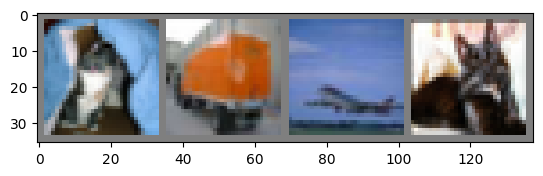

cat   truck plane cat  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Defining the model

In [47]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Loss, Optimizers, Training

In [48]:
# Defining Loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [49]:
# Training the network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.156
[1,  4000] loss: 1.865
[1,  6000] loss: 1.678
[1,  8000] loss: 1.565
[1, 10000] loss: 1.511
[1, 12000] loss: 1.435
[2,  2000] loss: 1.401
[2,  4000] loss: 1.346
[2,  6000] loss: 1.315
[2,  8000] loss: 1.283
[2, 10000] loss: 1.293
[2, 12000] loss: 1.243
Finished Training


In [52]:
# Saving the trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [53]:
# Loading the previosly used model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Testing the Model

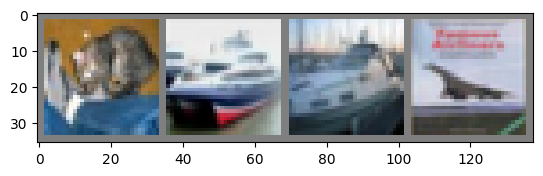

GroundTruth:  cat   ship  ship  plane


In [51]:
# Testing the CNN
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [54]:
outputs = net(images)

In [55]:
outputs

tensor([[-2.5786, -1.7662,  0.7766,  3.4431, -0.1013,  1.5552,  1.5399, -0.5042,
         -0.3152, -1.8727],
        [ 5.8672,  8.3023, -3.6338, -3.0758, -3.5082, -4.6207, -5.2698, -4.5514,
          8.4773,  4.1041],
        [ 2.9808,  2.9911, -0.1706, -0.9715, -1.0568, -2.1494, -2.3428, -2.2548,
          3.8948,  0.8558],
        [ 3.4191,  1.0352,  1.1004, -1.0473, -1.0972, -2.0548, -2.4937, -1.8692,
          4.5612, -0.2198]], grad_fn=<AddmmBackward0>)

In [56]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [57]:
# Prediction on entire test dataset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


### CrossEntropyLoss() manages size mismatch.

In [101]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [103]:
print(input)
print(target)

tensor([[-0.4806,  2.9307,  1.0299,  0.1008, -0.3049],
        [-0.0661,  0.0074,  0.2386,  0.4832, -0.0694],
        [ 0.7005, -0.1406, -1.4381, -1.0633,  0.4914]], requires_grad=True)
tensor([1, 4, 3])


In [102]:
print(input.shape)
print(target.shape)

torch.Size([3, 5])
torch.Size([3])


In [104]:
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

In [105]:
print(input)
print(target)

tensor([[-0.3777, -1.5205, -0.9397, -0.0687, -0.3297],
        [ 0.0052,  0.8550, -0.5257, -0.5459,  0.5689],
        [ 0.2600,  2.1576, -0.2835,  0.7501, -1.2757]], requires_grad=True)
tensor([[0.0888, 0.3716, 0.0298, 0.3108, 0.1990],
        [0.0897, 0.0427, 0.5596, 0.2509, 0.0569],
        [0.0848, 0.0800, 0.5338, 0.1752, 0.1261]])


In [106]:
print(input.shape)
print(target.shape)

torch.Size([3, 5])
torch.Size([3, 5])
